In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import transforms
import PIL 
import cv2

from IPython.display import clear_output, Image, display, HTML
import base64

import predict

import matplotlib.pyplot as plt
plt.style.use('default')

/home/azad/anaconda3/envs/bnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Labels = {
    0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 
    6: "G", 7: "H", 8: "I", 9: "K", 10: "L", 11: "M",
    12: "N", 13: "O", 14: "P", 15: "Q", 16: "R", 17: "S",
    18: "T", 19: "U", 20: "V", 21: "W", 22: "X", 23: "Y",
}

# Let's preprocess the inputted frame
data_transforms = transforms.Compose([
    transforms.Resize(28), 
    transforms.CenterCrop((28, 28)), 
    #transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.5],[0.5])
])


#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   ##Assigning the Device which will do the calculation
# model  = torch.load("Resnet50_Left_Pretrained_ver1.1.pth") #Load model to CPU
# model  = model.to(device)   #set where to run the model and matrix calculation
# model.eval()                #set the device to eval() mode for testing

def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=png)


#Set the Webcam 
def Webcam_720p(cap):
    cap.set(3,640)
    cap.set(4,480)

def argmax(prediction):
    prediction = prediction.cpu()
    prediction = prediction.detach().numpy()
    top_1 = np.argmax(prediction, axis=1)
    score = np.amax(np.exp(prediction))
    #score = '{:6f}'.format(score)
    prediction = top_1[0]
    result = Labels[prediction]

    return result,score


def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = PIL.Image.fromarray(image) # Webcam frames are numpy array format
                                       # Therefore transform back to PIL image
    print(image)                             
    image = data_transforms(image)
    image = image.float()
    #image = Variable(image, requires_autograd=True)
    #image = image.cuda()
    image = image.unsqueeze(0) #I don't know for sure but Resnet-50 model seems to only
                               #accpets 4-D Vector Tensor so we need to squeeze another
    return image                            #dimension out of our 3-D vector Tensor


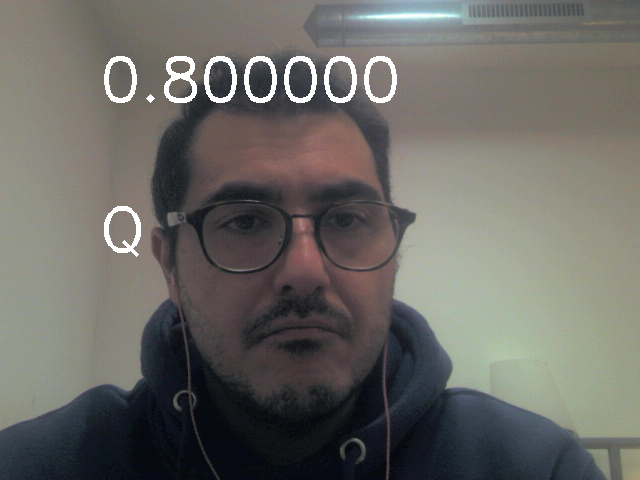

<PIL.Image.Image image mode=L size=640x480 at 0x7F30985C2400>


KeyboardInterrupt: 

In [3]:
# Let's start the real-time classification process!
                                  
cap = cv2.VideoCapture(0) #Set the webcam
Webcam_720p(cap)

fps = 0
show_score = 0
show_res = 'Nothing'
sequence = 0

while True:

    ret, frame = cap.read() # capture each frame
    
    if fps == 5:
        image = frame #image = frame[100:450,150:570]
        image_data = preprocess(image)
        result, score = predict.BCNN(image_data=image_data, nsamples=10)
        print(str(result) + str(score))
        fps = 0
        if score >= 0.5:
            show_res  = result
            show_score= '{:6f}'.format(score)
        else:
            show_res   = "Nothing"
            show_score = '{:6f}'.format(score)
            
        cv2.putText(frame, '%s' %(show_score),(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        cv2.putText(frame, '%s' %(show_res),(100,250), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
            
        try:
            clear_output(wait=True)
            #l=[]
            #bnn_sight = arrayShow(np.array(image_data.cpu()))
            img = arrayShow(frame)
            display(img)
            
            # grid = torchvision.utils.make_grid(image_data.cpu())
            # plt.figure(figsize=(8,8))
            # plt.imshow(np.transpose(grid, (1, 2, 0)))

            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
            
            
        except KeyboardInterrupt:
            cap.release()
        
    fps += 1

    #cv2.putText(frame, '(score = %.5f)' %(show_score), (100,300), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    #cv2.rectangle(frame,(200,150),(100,200), (250,0,0), 2)
    #cv2.imshow("ASL SIGN DETECTER", frame)


# release the cap object
cap.release()

# destroy all the windows
cv2.destroyAllWindows()